# Using LSTM to predict the Tokyo Stock Exchange variations

One of the first exercise we are proposed to do with Long Short Term Memory models is to try to predict the stock exchange variations.

When we look at the graphs, it's quite impressive to see the Training and Test line hug the real price so close, but how good are these predictions?

Hypothesis:
* We only try to predict the next day, because more than that, the model just have no clue where things are going, and the accumulation of unknown just makes it even less reliable. So day traiding only
* Because values are normalized in order to train the model, the prediction will also be normalized, which means that it will not give a price. We could try to convert the value back to a real value, but is it really necessary? If the objective is just to guess which stock will go up, and how confident we are that it will go up, just a general indication (up/down) could be sufficient.

With these hypothesis, I tried to train a model that would look at the past value, and try to guess which stock should be purchased tomorrow morning, because it should be going up during the day.

## Conclusion
at the end

## Spoilers
I wouldn't use this to chose my investments

## Importing libraries

In [3]:
import matplotlib.pyplot as plt
# import seaborn
import json
from datetime import date
import datetime
# import random
import time
from os import path
import pandas as pd
import numpy as np
from scipy.stats import beta
from math import sqrt

import requests

# from pandas_datareader import data as dr

from html.parser import HTMLParser
from html.entities import name2codepoint

# pip install opencv-python matplotlib numpy scipy keras scikit-learn tensorflow

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

np.random.seed(42)

# pip install yfinance
import yfinance as yf

%matplotlib inline

# %load_ext autoreload
# %autoreload 2


# Load/Update of the list of symbols from Nikkei 225 site

This next cell checks if there is a nikkei225.json file in the current folder and loads it. If there isn't one, it will go recover the latest list on the official nikkei site. (# Nikkei 225: https://indexes.nikkei.co.jp/en/nkave/index/component?idx=nk225)

In [8]:
nfile = 'nikkei225.json'

class MyHTMLParser(HTMLParser):    
    def handle_starttag(self, tag, attrs):
        global dept, nikkei225, area, company, location
        
        dept += 1
        for attr in attrs:
            if attr[0] == 'class':
                if attr[1] == 'col-xs-11 col-sm-11' and dept == 8:
                    location = 0
                    company = {
                        'code': "",
                        'url': "",
                        'name': "",
                        'area': ""
                    }
                elif attr[1] == 'col-xs-3 col-sm-1_5' and dept == 8:
                    location = 1
            elif attr[0] == 'href' and location == 2:
                company['url'] = attr[1]
                location = 3

    def handle_endtag(self, tag):
        global dept
        dept -= 1

    def handle_data(self, data):
        global dept, nikkei225, area, company, location
        if location == 0 and dept == 8:
            print("Area:", data)
            company["area"] = data
            location = None
        elif location == 1 and dept == 8 and data not in ['Code', 'Company Name']:
            company['code'] = data + ".T"
            location = 2
        elif location == 3 and dept == 8:
            company['name'] = data
            nikkei225[company['code']] = dict(company)                

            
if path.exists(nfile):
    if (time.time() - path.getmtime(nfile) < (7 * 24 * 60 * 60)): # Update the list every week
        print('the current {} file is good enough'.format(nfile))
        with open(nfile, 'r') as infile:
            nikkei225 = json.load(infile)
    else:
        print('the current {} file is too old'.format(nfile))
        nikkei225 = {}
        
if len(nikkei225.keys()) == 0:
    nikkei225 = {}
    company = {}
    area = ""
    dept = 0
    location = None
    
    r = requests.get('https://indexes.nikkei.co.jp/en/nkave/index/component?idx=nk225')
    print('http get status', r.status_code, 'length', len(r.text))
    parser = MyHTMLParser()
    parser.feed(r.text)
    
    with open(nfile, 'w') as outfile:
        json.dump(nikkei225, outfile)

print('Number of symbols in the Nikkei 225 index: {}'.format(len(nikkei225.keys())))

the current nikkei225.json file is good enough
Number of symbols in the Nikkei 225 index: 225


# Download the current symbol values from the Yahoo Finance Site

In [5]:
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
print('today', today.strftime("%Y-%m-%d"), 'tomorrow', tomorrow.strftime("%Y-%m-%d"))

tickers = list(nikkei225.keys())
start_date = '2019-01-01'
end_date = tomorrow

today 2020-05-07 tomorrow 2020-05-08


In [29]:
# Downloading the values from Yahoo Finance here
df_raw_nikkei225 = yf.download(tickers, start=start_date, end=end_date)

# Plot all the closing prices. this is a mess, but good to confirm that we have the data
# df_raw_nikkei225['Close'].plot(figsize=(16, 9))

[*********************100%***********************]  225 of 225 completed


In [30]:
# A bit of cleanup...
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
df_clean_nikkei2225 = df_raw_nikkei225.reindex(all_weekdays)
df_clean_nikkei2225 = df_clean_nikkei2225.fillna(method='ffill')
df_clean_nikkei2225.tail()

Adj Close                                                       \
              1332.T  1333.T 1605.T  1721.T  1801.T 1802.T 1803.T  1808.T   
2020-05-04     461.0  2215.0  673.5  2969.0  3245.0  913.0  818.0  1150.0   
2020-05-05     461.0  2215.0  673.5  2969.0  3245.0  913.0  818.0  1150.0   
2020-05-06     461.0  2215.0  673.5  2969.0  3245.0  913.0  818.0  1150.0   
2020-05-07     458.0  2212.0  677.0  3010.0  3360.0  934.0  848.0  1142.0   
2020-05-08     458.0  2212.0  677.0  3010.0  3360.0  934.0  848.0  1142.0   

                            ...     Volume                                   \
            1812.T  1925.T  ...     9502.T     9503.T     9531.T     9532.T   
2020-05-04  1075.0  2665.0  ...  1892700.0  3692700.0  1940300.0  1039700.0   
2020-05-05  1075.0  2665.0  ...  1892700.0  3692700.0  1940300.0  1039700.0   
2020-05-06  1075.0  2665.0  ...  1892700.0  3692700.0  1940300.0  1039700.0   
2020-05-07  1112.0  2650.5  ...  2878600.0  3342100.0  1656100.0  1305400.0   
2020-05-08  1112.0  2650.5  ...  2878600.0  3342100.0  1656100.0  1305400.0   

                                                                            
              9602.T     9613.T    9735.T    9766.T     9983.T      9984.T  
2020-05-04  337600.0  5975000.0  639400.0  784000.0  1540400.0  21139600.0  
2020-05-05  337600.0  5975000.0  639400.0  784000.0  1540400.0  21139600.0  
2020-05-06  337600.0  5975000.0  639400.0  784000.0  1540400.0  21139600.0  
2020-05-07  399900.0  3506700.0  466200.0  814700.0   750500.0  15944000.0  
2020-05-08  399900.0  3506700.0  466200.0  814700.0   750500.0  15944000.0  

[5 rows x 1350 columns]

In [31]:
# keeping a dataframe with just the close values
df_close_nikkei225 = df_clean_nikkei2225['Close']

# keeping a dataframe with the relevant values used for our model
df_relev_nikkei225 = df_clean_nikkei2225[['Close', 'High', 'Low', 'Volume']]
df_relev_nikkei225.tail()

Close                                                       \
           1332.T  1333.T 1605.T  1721.T  1801.T 1802.T 1803.T  1808.T   
2020-05-04  461.0  2215.0  673.5  2969.0  3245.0  913.0  818.0  1150.0   
2020-05-05  461.0  2215.0  673.5  2969.0  3245.0  913.0  818.0  1150.0   
2020-05-06  461.0  2215.0  673.5  2969.0  3245.0  913.0  818.0  1150.0   
2020-05-07  458.0  2212.0  677.0  3010.0  3360.0  934.0  848.0  1142.0   
2020-05-08  458.0  2212.0  677.0  3010.0  3360.0  934.0  848.0  1142.0   

                            ...     Volume                                   \
            1812.T  1925.T  ...     9502.T     9503.T     9531.T     9532.T   
2020-05-04  1075.0  2665.0  ...  1892700.0  3692700.0  1940300.0  1039700.0   
2020-05-05  1075.0  2665.0  ...  1892700.0  3692700.0  1940300.0  1039700.0   
2020-05-06  1075.0  2665.0  ...  1892700.0  3692700.0  1940300.0  1039700.0   
2020-05-07  1112.0  2650.5  ...  2878600.0  3342100.0  1656100.0  1305400.0   
2020-05-08  1112.0  2650.5  ...  2878600.0  3342100.0  1656100.0  1305400.0   

                                                                            
              9602.T     9613.T    9735.T    9766.T     9983.T      9984.T  
2020-05-04  337600.0  5975000.0  639400.0  784000.0  1540400.0  21139600.0  
2020-05-05  337600.0  5975000.0  639400.0  784000.0  1540400.0  21139600.0  
2020-05-06  337600.0  5975000.0  639400.0  784000.0  1540400.0  21139600.0  
2020-05-07  399900.0  3506700.0  466200.0  814700.0   750500.0  15944000.0  
2020-05-08  399900.0  3506700.0  466200.0  814700.0   750500.0  15944000.0  

[5 rows x 900 columns]

## Graphing a single symbol with rolling averages (5, 20, 50 days)

1332.T


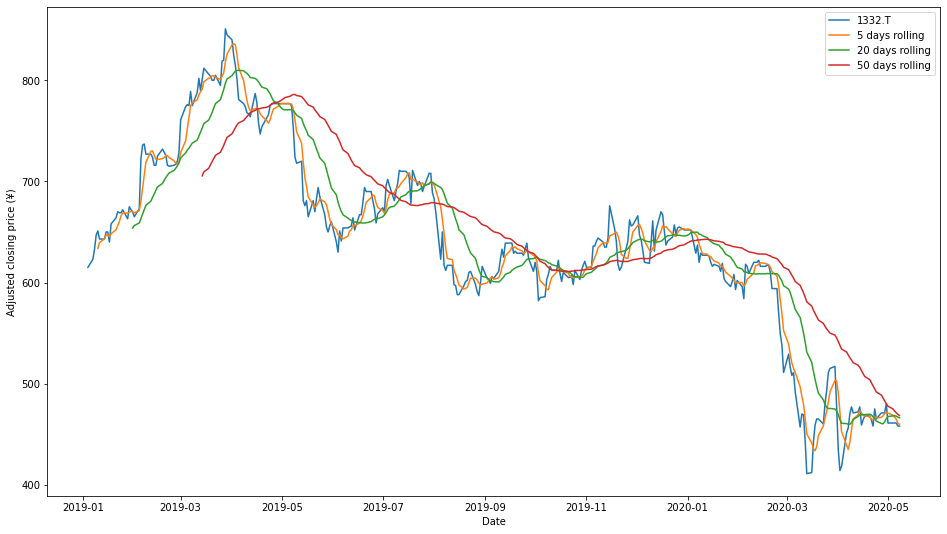

In [32]:
## Tests on a single symbol: the first one

for symbol in list(df_close_nikkei225.keys())[:1]:
    print(symbol)
    # Get the MSFT timeseries. This now returns a Pandas Series object indexed by date.
    
    wtv = df_close_nikkei225.loc[:, symbol]
    # msft = close.loc[:]

    # Calculate the 20 and 100 days moving averages of the closing prices
    roll_5_days = wtv.rolling(window=5).mean()
    roll_20_days = wtv.rolling(window=20).mean()
    roll_50_days = wtv.rolling(window=50).mean()
    roll_100_days = wtv.rolling(window=100).mean()

    # Plot everything by leveraging the very powerful matplotlib package
    fig, ax = plt.subplots(figsize=(16,9))

    ax.plot(wtv.index, wtv, label=symbol)
    ax.plot(roll_5_days.index, roll_5_days, label='5 days rolling')
    ax.plot(roll_20_days.index, roll_20_days, label='20 days rolling')
    ax.plot(roll_50_days.index, roll_50_days, label='50 days rolling')
    # ax.plot(roll_100_days.index, roll_100_days, label='100 days rolling')

    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted closing price (¥)')
    ax.legend()

## Defining the model

The next cell defines the function that will return a LSTN RNN.

In [33]:
# LSTM Related functions

def build_part1_RNN(window_size, n_features = 1, nodes = 5):
    model = Sequential()
    model.add(LSTM(nodes, activation='tanh', input_shape=(window_size, n_features), dropout=0.2))
    model.add(Dense(1))
    
    # build model using keras documentation recommended optimizer initialization
    optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

    # compile the model
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    # model.compile(loss='mae', optimizer='adam')
        
    return model

## Preparing the data to train the model

The `window_transform_3d_series` function returns the series days (X) and the value that need to be predicted (y)

In [34]:
# convert series to supervised learning
def window_transform_3D_series(df, window_size, out=['Close']):
    # containers for input/output pairs
    X = []
    y = []
    
    for ii in range(len(df) - window_size):
        X.append(list(df.iloc[ii:ii+window_size].values))
        y.append(df.iloc[ii+window_size][out].values)

    # reshape each
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:3])
    y = np.asarray(y)
    y.shape = (len(y),1)
    

    return X, y

def mean_beta(a, b):
    mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
    return mean

if False: #testing function, just to confirm that the values are properly returned by window_transform_3D_series
    window_size = 8
#     features = ['Close', 'Low', 'High', 'Volume']
    features = ['Close']
    n_features = len(features)

    for symbol in list(df_close_nikkei225.keys())[:1]:
        print(symbol)
        df = df_relev_nikkei225.loc[:, [(x, symbol) for x in features]]

        df_scaled=(df-df.mean())/df.std()

        X,y = window_transform_3D_series(df_scaled.fillna(0).head(20),window_size, 'Close')
        print([{"X": list(X[i][-1]),"y": y[i][0]} for i in range(len(y))])

## Initializing the model

In [37]:
# window the data using your windowing function
window_size = 8
features = ['Close', 'Low', 'High', 'Volume']
# features = ['Close']
n_features = len(features)

error_objective = 0.02

epochs = 250
batch_size = 50
nodes = window_size * 3

model = build_part1_RNN(window_size, n_features, nodes)

* 1332.T NIPPON SUISAN KAISHA, LTD. training error = 0.049 (False), testing error: 0.949 (False)
* 1333.T MARUHA NICHIRO CORP. training error = 0.037 (False), testing error: 0.353 (False)
* 1605.T INPEX CORP. training error = 0.021 (False), testing error: 1.204 (False)
* 1721.T COMSYS HOLDINGS CORP. training error = 0.042 (False), testing error: 0.282 (False)
* 1801.T TAISEI CORP. training error = 0.039 (False), testing error: 0.130 (False)
* 1802.T OBAYASHI CORP. training error = 0.023 (False), testing error: 0.201 (False)
* 1803.T SHIMIZU CORP. training error = 0.023 (False), testing error: 0.432 (False)
* 1808.T HASEKO CORP. training error = 0.043 (False), testing error: 0.142 (False)
* 1812.T KAJIMA CORP. training error = 0.034 (False), testing error: 0.191 (False)
* 1925.T DAIWA HOUSE IND. CO., LTD. training error = 0.027 (False), testing error: 0.547 (False)
* 1928.T SEKISUI HOUSE, LTD. training error = 0.026 (False), testing error: 0.047 (False)
* 1963.T JGC HOLDINGS CORP. train

* 5711.T MITSUBISHI MATERIALS CORP. training error = 0.022 (False), testing error: 0.260 (False)
* 5713.T SUMITOMO METAL MINING CO., LTD. training error = 0.029 (False), testing error: 0.466 (False)
* 5714.T DOWA HOLDINGS CO., LTD. training error = 0.010 (True), testing error: 0.332 (False)
* 5801.T FURUKAWA ELECTRIC CO., LTD. training error = 0.043 (False), testing error: 0.160 (False)
* 5802.T SUMITOMO ELECTRIC IND., LTD. training error = 0.019 (True), testing error: 0.217 (False)
* 5803.T FUJIKURA LTD. training error = 0.029 (False), testing error: 0.139 (False)
* 5901.T TOYO SEIKAN GROUP HOLDINGS, LTD. training error = 0.046 (False), testing error: 0.204 (False)
* 6098.T RECRUIT HOLDINGS CO., LTD. training error = 0.022 (False), testing error: 0.244 (False)
* 6103.T OKUMA CORP. training error = 0.031 (False), testing error: 0.314 (False)
* 6113.T AMADA CO., LTD. training error = 0.026 (False), testing error: 0.239 (False)
* 6178.T JAPAN POST HOLDINGS CO., LTD. training error = 0.04

* 8601.T DAIWA SECURITIES GROUP INC. training error = 0.041 (False), testing error: 0.131 (False)
* 8604.T NOMURA HOLDINGS, INC. training error = 0.041 (False), testing error: 0.093 (False)
* 8628.T MATSUI SECURITIES CO., LTD. training error = 0.033 (False), testing error: 0.099 (False)
* 8630.T SOMPO HOLDINGS, INC. training error = 0.029 (False), testing error: 0.543 (False)
* 8725.T MS&AD INSURANCE GROUP HOLDINGS, INC. training error = 0.025 (False), testing error: 0.378 (False)
* 8729.T SONY FINANCIAL HOLDINGS INC. training error = 0.048 (False), testing error: 0.291 (False)
* 8750.T DAI-ICHI LIFE HOLDINGS, INC. training error = 0.041 (False), testing error: 0.260 (False)
* 8766.T TOKIO MARINE HOLDINGS, INC. training error = 0.027 (False), testing error: 0.367 (False)
* 8795.T T&D HOLDINGS, INC. training error = 0.040 (False), testing error: 0.231 (False)
* 8801.T MITSUI FUDOSAN CO., LTD. training error = 0.015 (True), testing error: 0.616 (False)
* 8802.T MITSUBISHI ESTATE CO., LTD

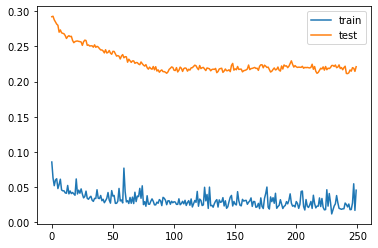

CPU times: user 42min 51s, sys: 9min 21s, total: 52min 12s
Wall time: 32min 53s


In [38]:
%%time

# for symbol in list(df_close_nikkei225.keys())[:1]:
for symbol in sorted([x for x in nikkei225.keys()]):# if nikkei225[x]['area'] == 'Pharmaceuticals']:
    df = df_relev_nikkei225.loc[:, [(x, symbol) for x in features]]
    
    df_scaled=(df-df.mean())/df.std()
    
    X,y = window_transform_3D_series(df_scaled.fillna(0), window_size, 'Close')
    
    train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point
    
    X_train = X[:train_test_split,:]
    y_train = y[:train_test_split]
    
    # keep the last chunk for testing
    X_test = X[train_test_split:,:]
    y_test = y[train_test_split:]
    
    # NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
    X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, n_features)))
    X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, n_features)))
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0, shuffle=False)
    
    # generate predictions for training
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # print out training and testing errors
    training_error = model.evaluate(X_train, y_train, verbose=0)
    testing_error = model.evaluate(X_test, y_test, verbose=0)
    print('* {} {} training error = {:0.3f} ({}), testing error: {:0.3f} ({})'.format(
        symbol, nikkei225[symbol]['name'], 
        training_error, training_error < error_objective, 
        testing_error, testing_error < error_objective
    ))
    
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## How does the predictions of the last training cycle look like?

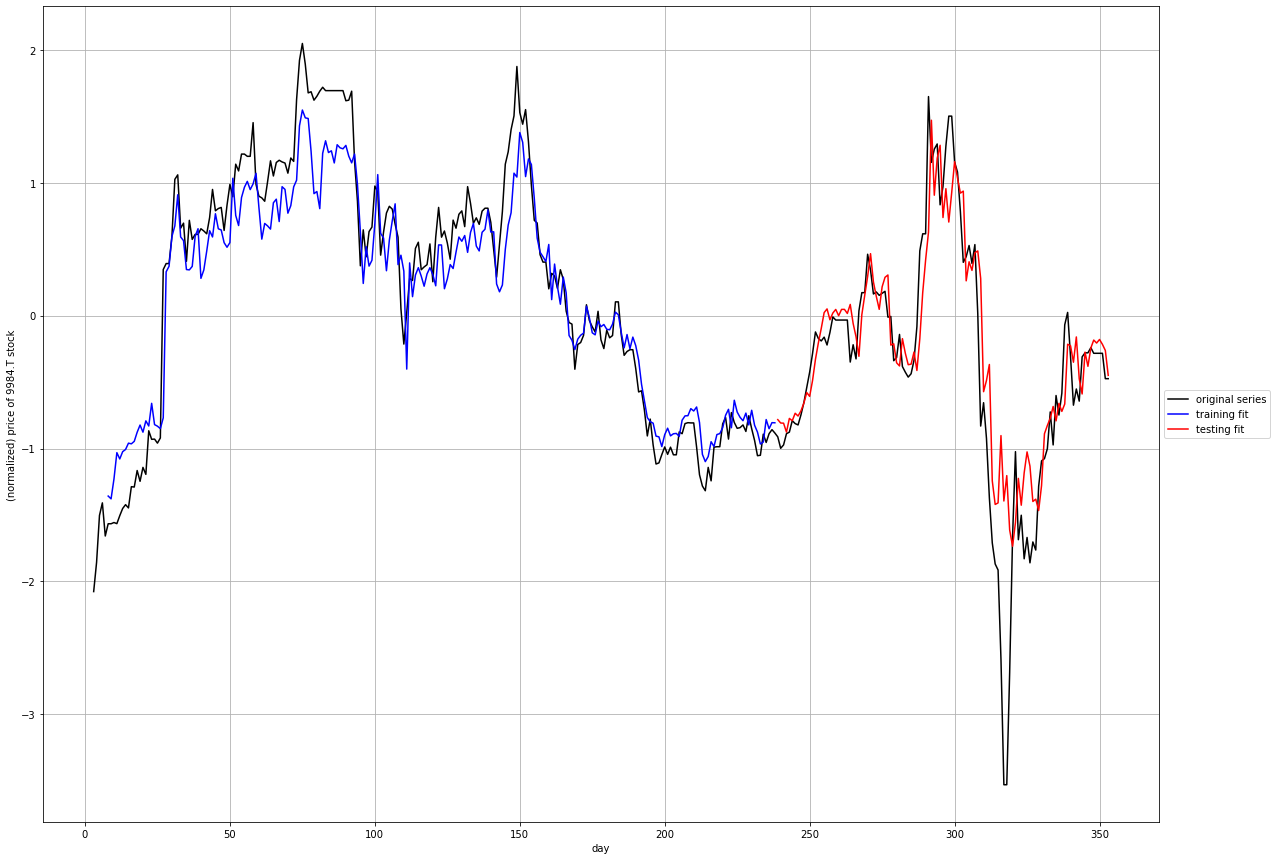

In [39]:
plt.figure(figsize=[20,15])
plt.grid(True)
plt.plot(df_scaled['Close'].reset_index(drop=True),color = 'k')


# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of {} stock'.format(symbol))
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Applying to reality: experimentations on Pharmaceutical

Now what? What can we do with this?

Let's say that we take all the Pharmaceutical companies listed in the Nikkei225, can we guess which ones will go up or down? How successful are the predictions? Can we trust them to help taking a decision about the next day's movements? 

This is what the following cell is doing. 
* It's going through pharmaceutical companies and rerun the training and testing values against the model. 
* While doing so, it will try to guess if the next day will go up or down, 
* and if it goes up, does it goes up significantly enough in order to make profit? (+0.25 normalized, this is arbitrary)
* For the one that does not qualify, we just forget about them. They can both be missed opportunities, or cases where value would really had declined.
* We then confirm if we did a good call to `buy` shares.
* At the last step, the code will display which symbol he thinks should be purchased, how many times the model was wrong, and how much capital we would have if we had followed all the predictions

4151.T KYOWA KIRIN CO., LTD. Pharmaceuticals True capital: 48.0
4502.T TAKEDA PHARMACEUTICAL CO., LTD. Pharmaceuticals False capital: 70.0
4503.T ASTELLAS PHARMA INC. Pharmaceuticals False capital: 30.5
4506.T SUMITOMO DAINIPPON PHARMA CO., LTD. Pharmaceuticals False capital: 0
4507.T SHIONOGI & CO., LTD. Pharmaceuticals False capital: 75.0
4519.T CHUGAI PHARMACEUTICAL CO., LTD. Pharmaceuticals True capital: 585.0
4523.T EISAI CO., LTD. Pharmaceuticals False capital: -590.0
4568.T DAIICHI SANKYO CO., LTD. Pharmaceuticals False capital: -850.0
4578.T OTSUKA HOLDINGS CO., LTD. Pharmaceuticals False capital: 219.0
4578.T


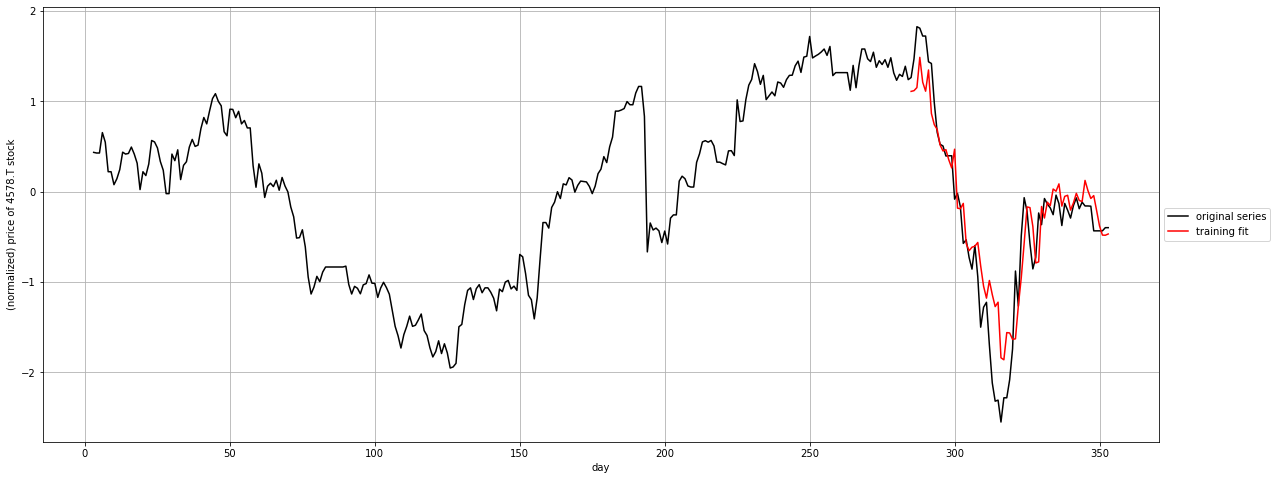

In [40]:
df_future = pd.DataFrame(columns = ['date', 'symbol', 'name', 'area', 'close', 'close_normalized', 'prediction', 'direction', 'buy', 'a', 'b', 'mean_beta', 'capital'])

for symbol in [x for x in nikkei225.keys() if nikkei225[x]['area'] == 'Pharmaceuticals']:    
    df = df_relev_nikkei225.loc[:, [(x, symbol) for x in features]]
    
    mean = df.mean()
    std = df.std()
    
    df_scaled=(df-mean)/std
    
    X,y = window_transform_3D_series(df_scaled.fillna(0), window_size, 'Close')
    
    train_test_split = int(np.ceil(4*len(y)/float(5)))   # set the split point
    
#     X_train = X[:train_test_split,:]
#     y_train = y[:train_test_split]
    
    # keep the last chunk for testing
    X_test = X[train_test_split:,:]
    y_test = y[train_test_split:]
    
    # NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, n_features] 
#     X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, n_features)))
    X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, n_features)))

    # generate predictions for training
#     train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    df_scaled_reindexed = df_scaled.reset_index()
    df_reindexed = df.reset_index()
    
    last_prediction = 4

    a = 1
    b = 1
    capital = 0

    for t in range(len(X_test-1)):
        
        scaled_sr = df_scaled_reindexed.iloc[train_test_split + t + window_size-1][['index', 'Close']]
        raw_sr = df_reindexed.iloc[train_test_split + t + window_size-1][['index', 'Close']]
        raw_tomorrow_sr = df_reindexed.iloc[train_test_split + t + window_size][['index', 'Close']]
        
        rday = str(raw_sr['index'].values[0]).split('T')[0]
        rtomorrow = str(raw_tomorrow_sr['index'].values[0]).split('T')[0]
        
        scaled_close = scaled_sr[('Close', symbol)]
        raw_close = raw_sr[('Close', symbol)]
        
        predicted = test_predict[t][0]
        decision = False
        
        if predicted < last_prediction:
            guess = 'Down'.format(predicted)
        else:
            guess = 'Up'.format(predicted)
            if predicted > last_prediction + 0.25:
                decision = True
        
        
        if len(X_test) > t+1:
            scaled_next = X_test[t+1][-1][0]
            raw_next = raw_tomorrow_sr[('Close', symbol)]
            
            profit =  raw_next - raw_close
            success = False
            
            if (decision and predicted > last_prediction and raw_next > raw_close) or (not decision and profit <= 0):
                success = True
            
            if decision:
                capital += profit
                if success:
                    a+=1
                else:
                    b+=1

                if success and False:
                    print('{} close: {} ({:0.3f}), pred: {}, buy: {}, next: {} ({:0.3f}), ¥: {:0.0f} right: {}'.format(
                        rday, raw_close, scaled_close, guess, decision, raw_next, scaled_next, profit, success
                    ))
        else:
            item = {
                'symbol': symbol,
                'name': nikkei225[symbol]['name'],
                'area': nikkei225[symbol]['area'],
                'date': rday,
                'close': raw_close,
                'close_normalized': scaled_close, 
                'prediction': predicted, 
                'direction': guess, 
                'buy': decision, 
                'a': a, 
                'b': b, 
                'mean_beta': mean_beta(a,b),
                'capital': capital
            }
            
            df_future = df_future.append(item, ignore_index=True)
            print("{} {} {} {} capital: {}".format(item['symbol'], item['name'], item['area'], item['buy'], capital))
        
        last_prediction = predicted
        
if True:
    print(symbol)
    plt.figure(figsize=[20,8])
    plt.grid(True)
    plt.plot(df_scaled['Close'].reset_index(drop=True),color = 'k')

    # plot training set prediction
    split_pt = train_test_split + window_size 
#     plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

    # plot testing set prediction
    plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

    # pretty up graph
    plt.xlabel('day')
    plt.ylabel('(normalized) price of {} stock'.format(symbol))
    plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

        

## According to our model, which stock is expected to rise tomorrow?

In [41]:
df_future[df_future['buy'] == True].sort_values(['mean_beta'], ascending=False)

,date,symbol,name,area,close,close_normalized,prediction,direction,buy,a,b,mean_beta,capital
0,2020-05-07,4151.T,"KYOWA KIRIN CO., LTD.",Pharmaceuticals,2568.0,1.392950,1.009109,Up,True,7,8,0.4666666666666667,48.0
5,2020-05-07,4519.T,"CHUGAI PHARMACEUTICAL CO., LTD.",Pharmaceuticals,13255.0,2.133757,1.637504,Up,True,5,6,0.45454545454545453,585.0


## How about the other stocks, what should happen to them?

In [42]:
df_future.sort_values(['mean_beta'], ascending=False)

,date,symbol,name,area,close,close_normalized,prediction,direction,buy,a,b,mean_beta,capital
2,2020-05-07,4503.T,ASTELLAS PHARMA INC.,Pharmaceuticals,1813.5,1.003820,0.802051,Up,False,8,5,0.6153846153846154,30.5
6,2020-05-07,4523.T,"EISAI CO., LTD.",Pharmaceuticals,7412.0,0.150559,0.270643,Up,False,6,5,0.5454545454545454,-590.0
1,2020-05-07,4502.T,"TAKEDA PHARMACEUTICAL CO., LTD.",Pharmaceuticals,3698.0,-0.847653,-0.829364,Down,False,2,2,0.5,70.0
3,2020-05-07,4506.T,"SUMITOMO DAINIPPON PHARMA CO., LTD.",Pharmaceuticals,1468.0,-1.197832,-0.989728,Down,False,1,1,0.5,0.0
0,2020-05-07,4151.T,"KYOWA KIRIN CO., LTD.",Pharmaceuticals,2568.0,1.392950,1.009109,Up,True,7,8,0.4666666666666667,48.0
5,2020-05-07,4519.T,"CHUGAI PHARMACEUTICAL CO., LTD.",Pharmaceuticals,13255.0,2.133757,1.637504,Up,True,5,6,0.45454545454545453,585.0
4,2020-05-07,4507.T,"SHIONOGI & CO., LTD.",Pharmaceuticals,5827.0,-0.797532,-0.742211,Down,False,2,3,0.4,75.0
8,2020-05-07,4578.T,"OTSUKA HOLDINGS CO., LTD.",Pharmaceuticals,4154.0,-0.399128,-0.469203,Up,False,3,6,0.3333333333333333,219.0
7,2020-05-07,4568.T,"DAIICHI SANKYO CO., LTD.",Pharmaceuticals,7614.0,1.161223,0.827659,Up,False,2,7,0.2222222222222222,-850.0


### Descriptions of the columns

* date: current date
* symbol: symbol on the Tokyo Stock Exchange (nikkei)
* name: official company name
* area: The nikkei is grouped in multiple areas
* close: closing price
* close_normalized: all values are normalized, this is the value once normalized
* prediction: the model predict that the next close_normalized value should be of x (also normalized)
* direction: here we are comparing against the last prediction value, because often the close value and the prediction value aren't exactly the same
* buy: should we buy or not?
* a: this to calculate the mean beta distribution: a == successfully predicted the next day during training
* b: this to calculate the mean beta distribution: b == failed to predict the next day during training
* mean_beta: mean beta distribution, what is the percentage of success of the model at predicting the model for that symbol
* capital: this is just to toy around. starting with a capital of 0 on 2019-01-01, if we buy when the model tells to buy, how much yens would we have a the end?

# Conclusion

The predictions from the LSTM RNN seems to be following the reality, but if we try to use these predictions to take purchasing decisions, we can see that the results look like a coin toss. The number of successes VS failures are quite around 50%, which is consistant with a random guess.

Can we use this in real life? I wouldn't.